# A/A tests (2 / 3 part)

## 3. Perform A/A testing
When we doing some experimental tests (A/B tests), we want to know, that before the experiment our data is identical between groups. If the group data already differs, so what's the reason to do the tests?

We want to know that our splitted data are identical to each other not just by seeing the data, but after we get some tests results. The main reason to do A/A test is to get statistical reason that our data are identical for now, before experiment.

In [1]:
from config import connection
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from aa_functions import run_aatest

import numpy as np
import pandas as pd
import pandahouse as ph
import seaborn as sns

## 3.1 Get the data

In [2]:
# get the same data, as we did it in the 1st part
first_date = '2022-07-06'
last_date = '2022-07-12'

metric = f"""
    SELECT
        user_id,
        exp_group,
        countIf(action='like') / countIf(action='view') as ctr
    FROM
        simulator_20220820.feed_actions
    WHERE
        toDate(time) between '{first_date}' and '{last_date}' AND
        exp_group IN [2, 3]
    GROUP BY
        user_id, exp_group
"""
df = ph.read_clickhouse(metric, connection=connection)
df.head()

,user_id,exp_group,ctr
0,115383,3,0.305556
1,123580,3,0.163043
2,131473,2,0.175676
3,23985,2,0.181818
4,24523,2,0.141667


## 3.2 Do A/A test

In [3]:
group1 = df[df['exp_group'] == 2]['ctr']
group2 = df[df['exp_group'] == 3]['ctr']

In [4]:
def check_with_ttest(a, b):
    stat, p = ttest_ind(a, b, equal_var=False)
    if p < 0.05:
        print("[INFO] The p-value is less than 0.05, the data statistically differs")
        print("[INFO] Statistic: ", stat)
        print("[INFO] P value: ", p)
    else:
        print("[INFO] The p-value is greater than 0.05, the data doesn't differs from each other")
        print("[INFO] Statistic: ", stat)
        print("[INFO] P value: ", p)


In [5]:
def check_with_mannwhitneyu(a, b):
    stat, p = mannwhitneyu(a, b)
    if p < 0.05:
        print("[INFO] The p-value is less than 0.05, the data statistically differs")
        print("[INFO] Statistic: ", stat)
        print("[INFO] P value: ", p)
    else:
        print("[INFO] The p-value is greater than 0.05, the data doesn't differs from each other")
        print("[INFO] Statistic: ", stat)
        print("[INFO] P value: ", p)

In [6]:
check_with_ttest(group1, group2)

[INFO] The p-value is greater than 0.05, the data doesn't differs from each other
[INFO] Statistic:  -0.7393597924958364
[INFO] P value:  0.45969873156476293


In [7]:
check_with_mannwhitneyu(group1, group2)

[INFO] The p-value is greater than 0.05, the data doesn't differs from each other
[INFO] Statistic:  36124728.5
[INFO] P value:  0.5177480614337441


## 3.3 Run many tests
If we do our t-test many times (10k), supposed that our data are statistically identical, we should get statistically significant differences only that percent of times, as we set the threshold of p-value. For example, if we set p-value threshold to 0.05, we assume that we'll get significances in 5% of all experiments.

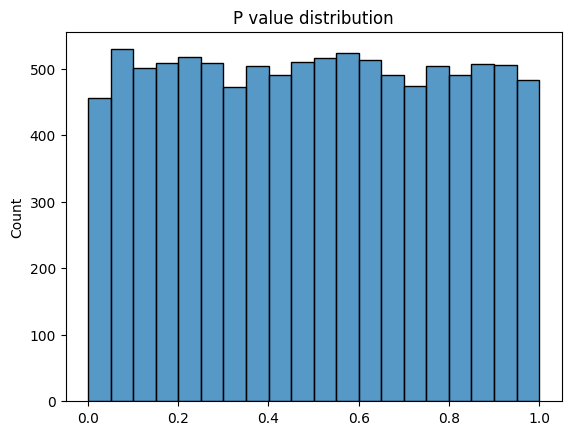

,Result
Full TTest Pvalue,0.46
Percent of tests lower 0.1 pvalue thresh,9.79
Percent of tests lower 0.05 pvalue thresh,4.55
Percent of tests lower 0.01 pvalue thresh,0.88


In [8]:
run_aatest(group1, group2, n_tests=10000, n_samples=500)

### What we did here:
1. First of all we did T-test on 2 groups again and got the same result as before (0.46), which is greater than 0.05
2. We ran 10k tests and for each test we took 500 samples from each group and T-tests them
3. After that we have 10k p values. P values distribution is above. This means, if we run many tests, we'll get uniform distribution of chances to get different significances
4. Calculate, how many tests showed a result less than the following thresholds: 0.1, 0.05, 0.01
5. In Result table we see, that the threshold number is really close to its percent of number of tests. The number of P values, that lower 0.1 is 10% of data, for 0.05 is 5% of data and for 0.01 is 1% of data